##### `Nom et prenom :`
##### `Numéro de groupe`

# **Résolution de problèmes à l'aide des bibliothèques Scikit learn et Pycaret** 

Ce cahier de notes présente une série d'exercices à résoudre en utilisant les fonctionnalités du package ou de la bibliothèque `pandas`. Chaque exercice doit être résolu à la suite de chaque énoncé, en expliquant de façon claire et concise les étapes utilisées pour y répondre. Les exercices doivent impérativement être résolus à l'aide des fonctions disponibles dans des bibliothèque demandées 

### `Exercice 1`

Trouvez un jeu de données comportant au moins quatre variables et appliquez-y des techniques de prétraitement telles que l'imputation des valeurs manquantes et l'encodage OneHot. Vous devrez présenter à la fois le DataFrame original et le DataFrame après prétraitement

   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  
Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Pap

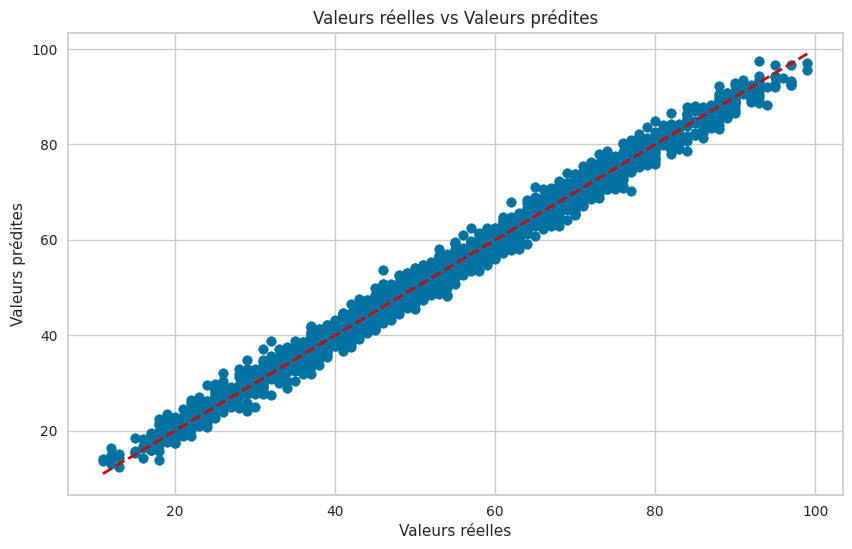

In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

# Chargement du jeu de données Iris
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['Species'] = iris.target_names[iris.target]

# Simulation de valeurs manquantes
np.random.seed(42) 
missing_indices = np.random.choice(df_iris.index, size=20, replace=False)
df_iris.loc[missing_indices, 'sepal length (cm)'] = np.nan

# Imputation des valeurs manquantes (stratégie : moyenne)
numeric_columns = iris.feature_names  # Noms des colonnes numériques
imputer = SimpleImputer(strategy="mean")
df_iris[numeric_columns] = imputer.fit_transform(df_iris[numeric_columns])

# Encodage OneHot pour la colonne 'Species'
encoder = OneHotEncoder(sparse_output=False, drop="first")
species_encoded = encoder.fit_transform(df_iris[["Species"]])
species_encoded_df = pd.DataFrame(species_encoded, columns=encoder.get_feature_names_out(["Species"]))

# Reconstruction du DataFrame final
df_iris_preprocessed = pd.concat([
    df_iris.drop(columns=["Species"]),
    species_encoded_df
], axis=1)

# Affichage des DataFrames
print("DataFrame Original :")
print(df_iris.head())

print("\nDataFrame Après Prétraitement :")
print(df_iris_preprocessed.head(100))

### `Exercice 2`

Une université américaine souhaite construire un modèle prédictif simple qui lui permette d'anticiper la performance des étudiants en fonction de leurs activités extrascolaires, de leur temps de repos, des heures d'étude, etc. À partir de l'ensemble des données fournies par l'université (`Student_Performance.csv`), répondre aux questions suivantes :

- Construire un modèle linéaire  multiple (avec scikitlearn) permettant de prédire la performance des étudiants. Pour ce faire, utilisez la technique de validation croisée avec 5 plis.
- Déterminer le RMSE globale à partir des résultats de la validation croisée.
- Quelles sont les valeurs des coefficients de régression obtenus ?
- Quelles sont les variables les plus influentes sur la performance des étudiants?
- Réaliser un graphique représentant les valeurs réelles en abscisse et les valeurs prédites en ordonnée pour l'ensemble de test, puis le superposer au graphique de la droite identité. Quel est le rôle de la droite identité dans ce graphique?

   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  
Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Pap

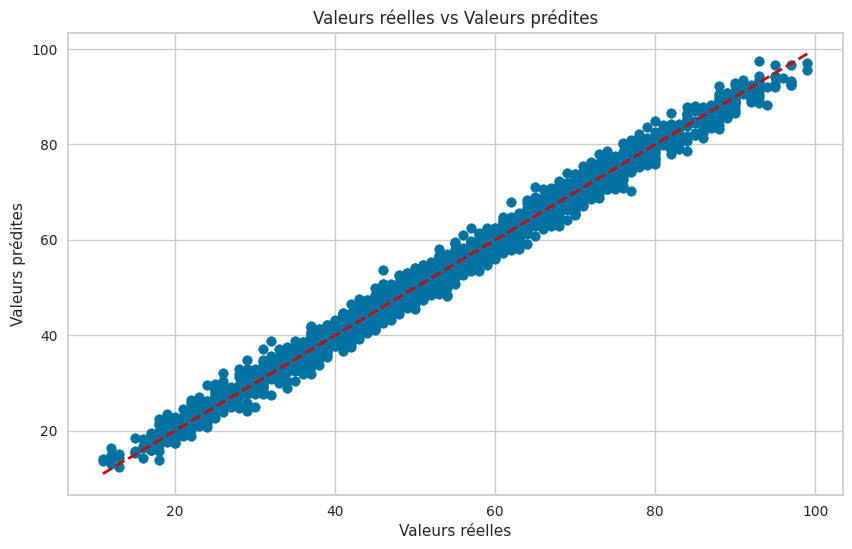

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


data = pd.read_csv('./data/Student_Performance.csv')
print(data.head())
print(data.dtypes)


categorical_columns = data.select_dtypes(include=['object']).columns
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.drop('Performance Index')

print("Colonnes catégorielles:", categorical_columns)
print("Colonnes numériques:", numeric_columns)


X = data.drop('Performance Index', axis=1)
y = data['Performance Index']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ])


model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


cv_results = cross_validate(model, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# 7. Calculer le RMSE
rmse = np.sqrt(-cv_results['test_score'].mean())
print(f"RMSE global : {rmse}")


model.fit(X, y)


feature_names = (numeric_columns.tolist() + 
                 model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_columns).tolist())


coefficients = pd.DataFrame(
    {'Feature': feature_names,
     'Coefficient': model.named_steps['regressor'].coef_}
)

print("Coefficients:")
print(coefficients)

coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
most_influential = coefficients.sort_values('Abs_Coefficient', ascending=False).head()
print("\nVariables les plus influentes:")
print(most_influential)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs réelles vs Valeurs prédites')
plt.show()



### `Exercice 3`

Avec le même jeu de données de l'exercice précédent, répondre aux questions suivantes :

- Trouver la valeur optimale des k plus proches voisins autour des 30 points. Pour ce faire, utiliser la validation croisée avec 5 plis (fold).
- Réaliser les graphiques de validation qui représentent l'erreur d'entraînement et l'erreur de validation (prenez comme métrique $r^2$).
- Réaliser un graphique représentant les valeurs réelles en ordonnée et les valeurs prédites en abscisse pour l'ensemble de test, puis le superposer au graphique de la droite identité.
- L'université vous demande de faire un choix entre le modèle linéaire (exemple précédent) et le modèle des k plus proches voisins. Lequel leur suggéreriez-vous et pour quelles raisons ?

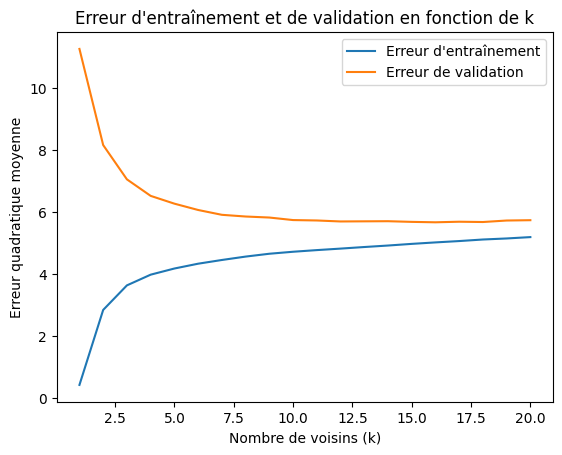

Nombre optimal de voisins k : 16


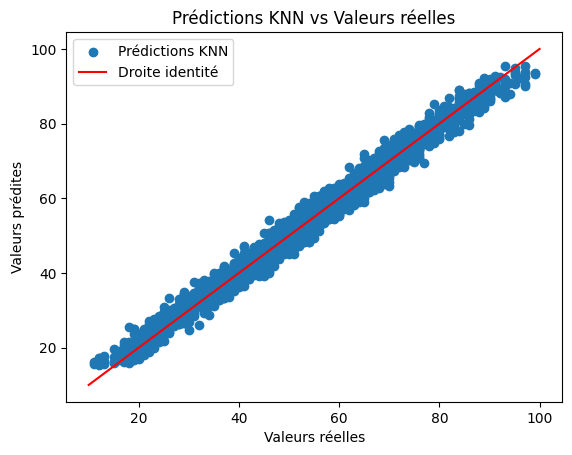

Erreur quadratique moyenne (KNN) : 5.390181640625
Erreur quadratique moyenne (Régression linéaire) : 4.082628398521856
La régression linéaire est préférable en termes d'erreur moyenne.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


data_path = './data/Student_Performance.csv'
data = pd.read_csv(data_path)

data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

X = data[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
y = data['Performance Index']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 21)
train_errors = []
val_errors = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    train_scores = []
    val_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        knn.fit(X_t, y_t)
        train_scores.append(mean_squared_error(y_t, knn.predict(X_t)))
        val_scores.append(mean_squared_error(y_v, knn.predict(X_v)))
    train_errors.append(np.mean(train_scores))
    val_errors.append(np.mean(val_scores))


plt.figure()
plt.plot(k_values, train_errors, label='Erreur d\'entraînement')
plt.plot(k_values, val_errors, label='Erreur de validation')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Erreur quadratique moyenne')
plt.legend()
plt.title('Erreur d\'entraînement et de validation en fonction de k')
plt.show()

optimal_k = k_values[np.argmin(val_errors)]
print(f"Nombre optimal de voisins k : {optimal_k}")


knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_pred_knn = knn_optimal.predict(X_test)


plt.figure()
plt.scatter(y_test, y_pred_knn, label='Prédictions KNN')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', label='Droite identité')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.legend()
plt.title('Prédictions KNN vs Valeurs réelles')
plt.show()

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"Erreur quadratique moyenne (KNN) : {mse_knn}")
print(f"Erreur quadratique moyenne (Régression linéaire) : {mse_lr}")

if mse_knn < mse_lr:
    print("Le modèle KNN est préférable en termes d'erreur moyenne.")
else:
    print("La régression linéaire est préférable en termes d'erreur moyenne.")


### `Exercice 4`

Un groupe de chercheurs en cancérologie dispose d'une base de données de patients présentant des tumeurs. Ces données contiennent une série de caractéristiques structurales des tumeurs, telles que la taille, la texture, le périmètre, etc. Les chercheurs souhaitent construire un modèle leur permettant de prédire des diagnostics futurs en fonction des caractéristiques de la tumeur. À partir de l'ensemble de données `breast_cancer_winsconsin.csv`, répondez aux questions suivantes:

- Réaliser l'entraînement d'un arbre de décision en optimisant la profondeur de l'arbre à l'aide de la validation croisée (k=5) et de l'index de Gini pour la construction de l'arbre. Vous devez également afficher la profondeur maximale optimisée ainsi que l'accuracy obtenue pendant la validation croisée.
- Réaliser le graphique de validation qui présente les courbes d'entraînement et de validation pour l'obtention de la profondeur maximale optimisée. Les graphiques doivent être présentés en tant que courbes d'erreur et non en tant que courbes d'accuracy. Réaliser aussi le graphique de votre arbre de décision obtenu
- Déterminer sous l'ensemble de test, la précision, le recall et le F1 score:
- Combien d'individus ont été mal classé dans l'ensemble de test?
- Selon votre modèle, quels sont les paramètres les plus influents pour déterminer le diagnostic?. Réalisez un graphique de barres qui montrera ces paramètres et leur influence sur le diagnostic.
- Extrayez la règle de décision de votre modèle et reprogrammez-la en utilisant des règles conditionnelles. Pour ce faire, créez une fonction avec des arguments d'entrée correspondant aux variables définies par la règle de décision.
- Comparez les résultats obtenus de votre fonction décisionnelle et ceux obtenus par la fonction `predict` de scikitlearn. Pour ce faire, créez un data frame et détectez s'il y a des incohérences dans les prédictions ou non (!faites attention aux arrondis). 

Profondeur optimale : 4
Erreur de validation minimale : 0.0857142857142857


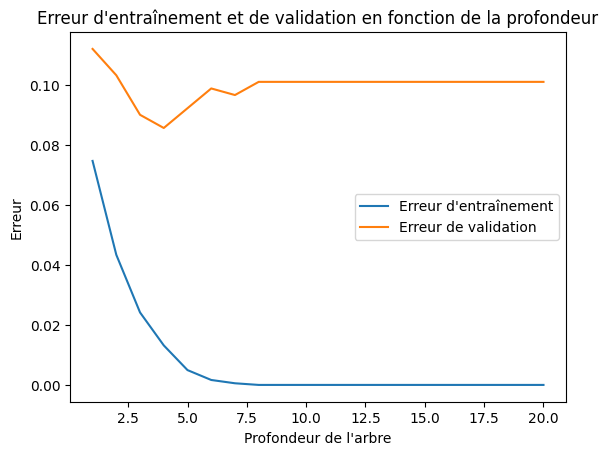

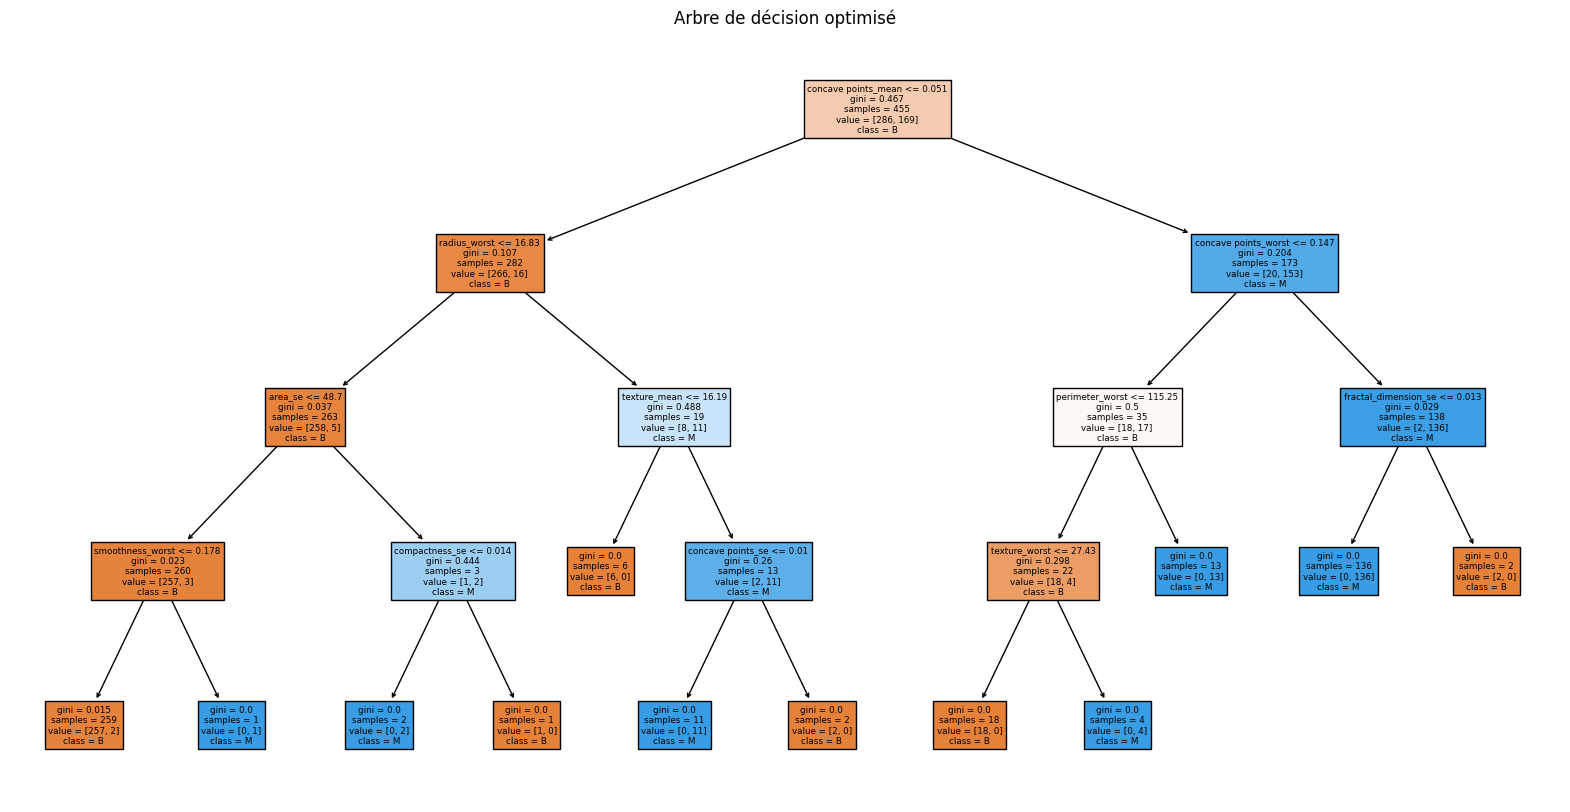

Précision : 0.9385964912280702
Rappel : 0.9069767441860465
F1 Score : 0.9176470588235294
Nombre d'individus mal classés : 7


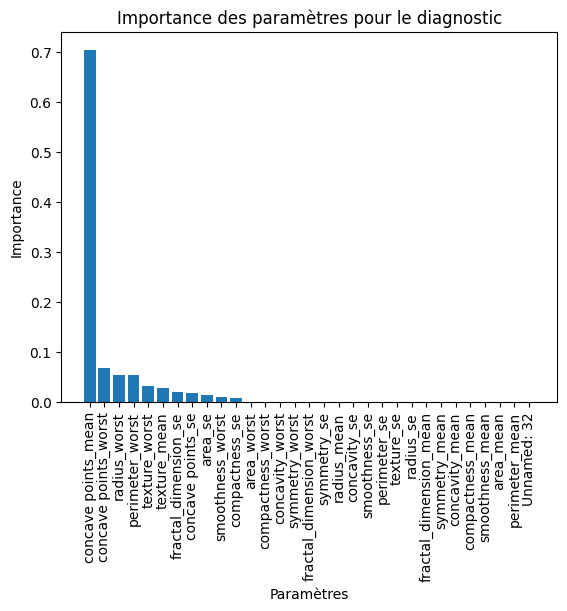

|--- concave points_mean <= 0.05
|   |--- radius_worst <= 16.83
|   |   |--- area_se <= 48.70
|   |   |   |--- smoothness_worst <= 0.18
|   |   |   |   |--- class: 0
|   |   |   |--- smoothness_worst >  0.18
|   |   |   |   |--- class: 1
|   |   |--- area_se >  48.70
|   |   |   |--- compactness_se <= 0.01
|   |   |   |   |--- class: 1
|   |   |   |--- compactness_se >  0.01
|   |   |   |   |--- class: 0
|   |--- radius_worst >  16.83
|   |   |--- texture_mean <= 16.19
|   |   |   |--- class: 0
|   |   |--- texture_mean >  16.19
|   |   |   |--- concave points_se <= 0.01
|   |   |   |   |--- class: 1
|   |   |   |--- concave points_se >  0.01
|   |   |   |   |--- class: 0
|--- concave points_mean >  0.05
|   |--- concave points_worst <= 0.15
|   |   |--- perimeter_worst <= 115.25
|   |   |   |--- texture_worst <= 27.43
|   |   |   |   |--- class: 0
|   |   |   |--- texture_worst >  27.43
|   |   |   |   |--- class: 1
|   |   |--- perimeter_worst >  115.25
|   |   |   |--- class: 1
|   

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

data_path = './data/breast_cancer_wisconsin.csv'
data = pd.read_csv(data_path)

data.drop(['id'], axis=1, inplace=True)
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})  # Encoder la cible (1 pour Malin, 0 pour Bénin)


X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
max_depths = range(1, 21)
train_errors = []
val_errors = []
best_depth = None
best_score = 0

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
    train_score = []
    val_score = []
    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        clf.fit(X_t, y_t)
        train_score.append(1 - accuracy_score(y_t, clf.predict(X_t)))
        val_score.append(1 - accuracy_score(y_v, clf.predict(X_v)))
    train_errors.append(np.mean(train_score))
    val_errors.append(np.mean(val_score))
    if np.mean(val_score) < best_score or best_depth is None:
        best_score = np.mean(val_score)
        best_depth = depth

print(f"Profondeur optimale : {best_depth}")
print(f"Erreur de validation minimale : {best_score}")


plt.figure()
plt.plot(max_depths, train_errors, label="Erreur d'entraînement")
plt.plot(max_depths, val_errors, label="Erreur de validation")
plt.xlabel("Profondeur de l'arbre")
plt.ylabel("Erreur")
plt.title("Erreur d'entraînement et de validation en fonction de la profondeur")
plt.legend()
plt.show()


final_model = DecisionTreeClassifier(max_depth=best_depth, criterion='gini', random_state=42)
final_model.fit(X_train, y_train)


plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X.columns, class_names=['B', 'M'], filled=True)
plt.title("Arbre de décision optimisé")
plt.show()


y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Précision : {accuracy}")
print(f"Rappel : {recall}")
print(f"F1 Score : {f1}")


conf_matrix = confusion_matrix(y_test, y_pred)
misclassified = conf_matrix[0, 1] + conf_matrix[1, 0]
print(f"Nombre d'individus mal classés : {misclassified}")


importance = final_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)


plt.figure()
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.title("Importance des paramètres pour le diagnostic")
plt.xlabel("Paramètres")
plt.ylabel("Importance")
plt.show()


tree_rules = export_text(final_model, feature_names=list(X.columns))
print(tree_rules)


feature_columns = list(X.columns)

def decision_rule(*args):
    data = dict(zip(feature_columns, args))
    if data['concave points_mean'] <= 0.05:
        if data['radius_worst'] <= 16.83:
            if data['area_se'] <= 48.70:
                if data['smoothness_worst'] <= 0.18:
                    return 0  # Bénin
                else:
                    return 1  # Malin
            else:
                if data['compactness_se'] <= 0.01:
                    return 1  # Malin
                else:
                    return 0  # Bénin
        else:
            if data['texture_mean'] <= 16.19:
                return 0  # Bénin
            else:
                if data['concave points_se'] <= 0.01:
                    return 1  # Malin
                else:
                    return 0  # Bénin
    else:
        if data['concave points_worst'] <= 0.15:
            if data['perimeter_worst'] <= 115.25:
                if data['texture_worst'] <= 27.43:
                    return 0  # Bénin
                else:
                    return 1  # Malin
            else:
                return 1  # Malin
        else:
            if data['fractal_dimension_se'] <= 0.01:
                return 1  # Malin
            else:
                return 0  # Bénin


X_test_subset = X_test[feature_columns].head(10)
manual_predictions = X_test_subset.apply(lambda row: decision_rule(*row), axis=1)
sklearn_predictions = final_model.predict(X_test_subset)


comparison_df = pd.DataFrame({
    'Vrai diagnostic': y_test.head(10).values,
    'Prédiction sklearn': sklearn_predictions,
    'Prédiction manuelle': manual_predictions
})
print(comparison_df)


incoherences = comparison_df[comparison_df['Prédiction sklearn'] != comparison_df['Prédiction manuelle']]
print(f"Incohérences détectées : {len(incoherences)}")

### `Exercice 5`

Plusieurs marques de voitures ont fait appel à une société environnementale canadienne afin qu'elle crée un modèle prédictif permettant d'estimer à l'avance les émissions de gaz à effet de serre (CO₂) produites par leurs véhicules. Ces constructeurs ont fourni à la société un jeu de données présentant des caractéristiques propres aux véhicules : marque, consommation, modèle, type de combustible, etc. En tant que data scientist junior de cette société, on vous demande d'utiliser un modèle de type Random Forest à l'aide de la bibliothèque PyCaret pour résoudre ce problème, en répondant aux questions suivantes:

- Entraînez un modèle de type Random Forest. Pour ce faire, suivez les indications suivantes :
  - Extrayez les 20 dernières lignes du data frame d'origine et stockez les dans un data frame nommé `data_CO2_emission_pred` pour effectuer des prédictions ultérieurement. Ces lignes doivent être éliminées du data frame sur lequel vous allez entraîner votre modèle. 
  - Appliquez une normalisation de type centrée réduite aux variables numériques.
  - Appliquez un encodage OneHot aux variables qualitatives nominales.
  - Utilisez un 5-fold pour optimiser le nombre d'arbres sur un ensemble d'entraînement d'un pourcentage de 70 % de l'échantillon initial.
- Traçez le graphique de validation de $r^2$ en fonction du nombre d'estimateur
- Quelles sont les caractéristiques les plus déterminantes de l'émission de $CO_2$ des véhicules ?
- À partir du modèle optimisé, effectuer les prédictions des données de véhicules dans le data frame `data_CO2_emission_pred`.

    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                   

,Description,Value
0,Session id,42
1,Target,CO2 Emissions(g/km)
2,Target type,Regression
3,Original data shape,"(7365, 12)"
4,Transformed data shape,"(7365, 30)"
5,Transformed train set shape,"(5155, 30)"
6,Transformed test set shape,"(2210, 30)"
7,Numeric features,6
8,Categorical features,5
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.8646,265.5816,16.2967,0.9249,0.0481,0.0161
1,4.3179,146.5898,12.1074,0.9552,0.0370,0.0151
2,4.7668,175.2609,13.2386,0.9467,0.0430,0.0165
3,4.0284,134.2527,11.5867,0.9611,0.0365,0.0147
4,5.4733,364.7559,19.0986,0.8981,0.0559,0.0176
Mean,4.6902,217.2882,14.4656,0.9372,0.0441,0.0160
Std,0.4952,86.8774,2.8345,0.0231,0.0073,0.0010


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.2620,78.2776,8.8475,0.9779,0.0294,0.0163
1,4.3985,65.6142,8.1003,0.9800,0.0280,0.0170
2,4.4341,69.6660,8.3466,0.9788,0.0319,0.0171
3,4.4460,67.4176,8.2108,0.9805,0.0336,0.0183
4,5.1573,173.8524,13.1853,0.9514,0.0395,0.0186
Mean,4.5396,90.9656,9.3381,0.9737,0.0325,0.0175
Std,0.3157,41.6703,1.9405,0.0112,0.0040,0.0009


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Caractéristiques les plus importantes :


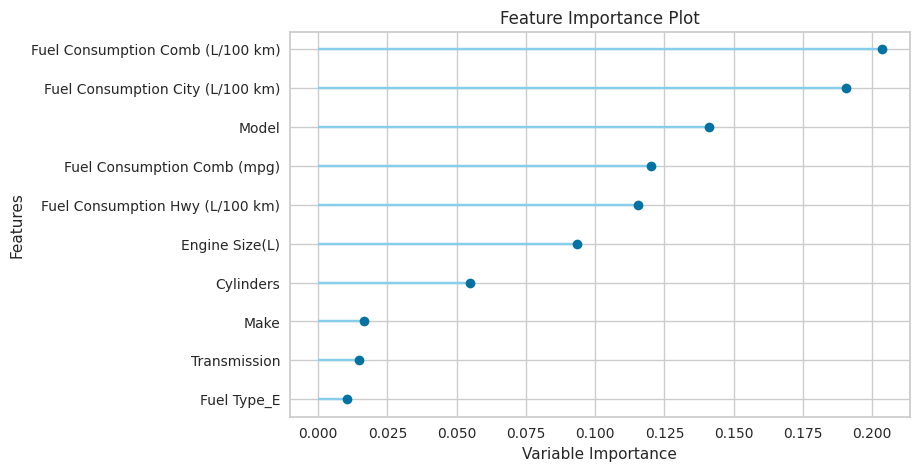

         MAE       MSE     RMSE      R2   RMSLE    MAPE
Fold                                                   
0     4.2620   78.2776   8.8475  0.9779  0.0294  0.0163
1     4.3985   65.6142   8.1003  0.9800  0.0280  0.0170
2     4.4341   69.6660   8.3466  0.9788  0.0319  0.0171
3     4.4460   67.4176   8.2108  0.9805  0.0336  0.0183
4     5.1573  173.8524  13.1853  0.9514  0.0395  0.0186
Les colonnes nécessaires pour tracer le graphique n'existent pas dans 'results'.


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.8616,7.8205,2.7965,0.9837,0.0135,0.0090



Prédictions sur les 20 dernières lignes :


KeyError: "['Label'] not in index"

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import *

data_path = './data/CO2_Emissions_Canada.csv'  
data = pd.read_csv(data_path)

# Vérifier les données
print(data.head())

# Préparer les données pour les prédictions
data_CO2_emission_pred = data.tail(20).reset_index(drop=True)
data = data.iloc[:-20].reset_index(drop=True)

# Initialisation de la configuration PyCaret
setup(
    data=data,
    target='CO2 Emissions(g/km)',
    train_size=0.7,
    normalize=True,
    categorical_features=['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type'],
    numeric_features=['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                      'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 
                      'Fuel Consumption Comb (mpg)'],
    fold=5,
    session_id=42
)

# Création et optimisation du modèle Random Forest
rf_model = create_model('rf')
optimized_rf_model = tune_model(rf_model, n_iter=10)

# Afficher les caractéristiques les plus importantes
print("\nCaractéristiques les plus importantes :")
plot_model(optimized_rf_model, plot='feature')

# Extraire les résultats du tuning
results = pull()
print(results.head())  # Vérifiez quelles colonnes sont disponibles dans 'results'

# Graphique des erreurs (si applicable)
if 'MSE' in results.columns and 'Mean' in results.columns:
    plt.figure(figsize=(8, 6))
    plt.plot(results.index, results['MSE'], marker='o')
    plt.xlabel('Itérations d\'optimisation')
    plt.ylabel('Erreur quadratique moyenne (MSE)')
    plt.title('MSE en fonction des itérations d\'optimisation')
    plt.grid()
    plt.show()
else:
    print("Les colonnes nécessaires pour tracer le graphique n'existent pas dans 'results'.")

# Évaluation du modèle
evaluate_model(optimized_rf_model)

# Prédictions sur les données réservées
data_CO2_emission_pred_encoded = predict_model(optimized_rf_model, data=data_CO2_emission_pred)

print("\nPrédictions sur les 20 dernières lignes :")
print(data_CO2_emission_pred_encoded[['Make', 'Model', 'CO2 Emissions(g/km)', 'Label']])
 

### `Exercice 6`
Une petite société de marketing souhaite faire une segmentation rapide de ses clients et se demande comment effectuer un clustering kmeans pour obtenir une réponse en temps réel. La société dispose d'un jeu de données `segmentation_data.csv` dont les spécifications de chaque variable se trouvent dans le fichier `segmentation data legend.xlsx`. Vous faites partie de l'équipe et ils vous demandent d'optimiser le nombre de clusters (celui-ci ne doit dépaser de 7) pour cette segmentation. Vous devez répondre aux questions suivantes:

- Créez une fonction de normalisation nommée min_max et appliquez-la au DataFrame avant de réaliser la clusterisation
- En utilisant la méthode de la silhouette, déterminez le nombre optimal de clusters. Vous devez afficher le graphique permettant d'arriver à ce résultat.

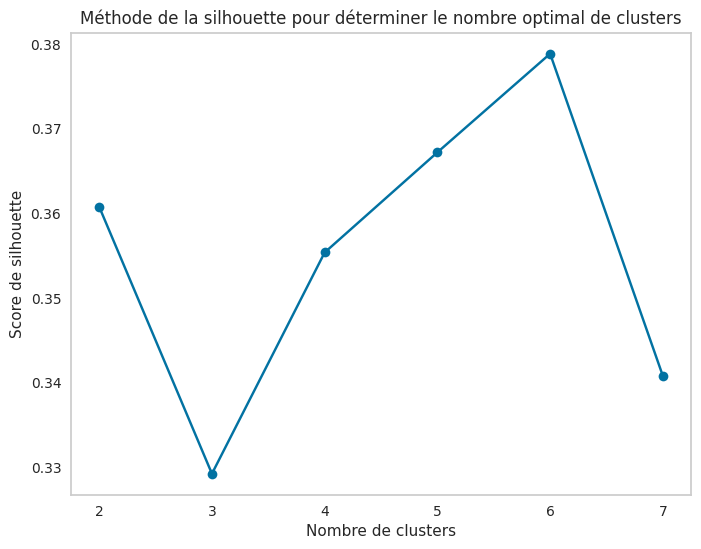

Le nombre optimal de clusters est : 6
Cluster
0    520
1    427
5    309
3    309
2    257
4    178
Name: count, dtype: int64
Données segmentées sauvegardées dans 'segmented_customers.csv'.


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


def load_data(file_path):
    return pd.read_csv(file_path)

def min_max(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def find_optimal_clusters(data, max_clusters=7):
    """
    Trouve le nombre optimal de clusters en utilisant la méthode de la silhouette.
    """
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)


    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title("Méthode de la silhouette pour déterminer le nombre optimal de clusters")
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Score de silhouette")
    plt.grid()
    plt.show()


    optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
    return optimal_clusters


def perform_kmeans(data, n_clusters):
    """
    Effectue le clustering KMeans et retourne les labels de cluster.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data)
    return data

if __name__ == "__main__":

    data_file = "./data/segmentation_data.csv"

    data = load_data(data_file)
    normalized_data = min_max(data)

    optimal_clusters = find_optimal_clusters(normalized_data)
    print(f"Le nombre optimal de clusters est : {optimal_clusters}")

    clustered_data = perform_kmeans(normalized_data, optimal_clusters)
    print(clustered_data['Cluster'].value_counts())

    clustered_data.to_csv("segmented_customers.csv", index=False)
    print("Données segmentées sauvegardées dans 'segmented_customers.csv'.")